Section 0 — Pre-requisites (paths + imports)

In [1]:
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# --- Robust project root detection ---
NOTEBOOK_DIR = Path.cwd().resolve()

root = NOTEBOOK_DIR
for _ in range(10):
    if (root / "src").exists() and (root / "data").exists():
        break
    root = root.parent
else:
    raise RuntimeError("Could not find project root (folder containing 'src' and 'data').")

PROJECT_ROOT = root
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "market_features.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("DATA exists:", DATA_PATH.exists())
print("OUT_DIR:", OUT_DIR)

# Load config weights (used in scoring)
from src.config import BASE_WEIGHTS
print("BASE_WEIGHTS:", BASE_WEIGHTS)


NOTEBOOK_DIR: /Users/lilsebo/Downloads/flo_capex_model/notebooks
PROJECT_ROOT: /Users/lilsebo/Downloads/flo_capex_model
DATA_PATH: /Users/lilsebo/Downloads/flo_capex_model/data/processed/market_features.csv
DATA exists: True
OUT_DIR: /Users/lilsebo/Downloads/flo_capex_model/outputs
BASE_WEIGHTS: {'demand': 0.3, 'enterprise_fit': 0.2, 'cloud_adjacency': 0.2, 'resilience': 0.15, 'capex_friction': -0.15}


Section 1 — Load dataset

In [2]:
df = pd.read_csv(DATA_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head()


Rows: 949
Columns: ['cbsa_code', 'cbsa_name', 'finance', 'information', 'logistics', 'manufacturing', 'professional_services', 'demand_index', 'primary_city', 'state', 'cbsa_name_u', 'is_candidate']


,cbsa_code,cbsa_name,finance,information,logistics,manufacturing,professional_services,demand_index,primary_city,state,cbsa_name_u,is_candidate
0,10020,"Abbeville, LA",322,117,454,491,295,423.8,Abbeville,LA,"ABBEVILLE, LA",False
1,10100,"Aberdeen, SD",978,135,429,3642,460,1775.3,Aberdeen,SD,"ABERDEEN, SD",False
2,10140,"Aberdeen, WA",483,130,432,2050,399,1077.7,Aberdeen,WA,"ABERDEEN, WA",False
3,10180,"Abilene, TX",3106,1015,2836,3632,1887,2991.6,Abilene,TX,"ABILENE, TX",False
4,10220,"Ada, OK",498,87,297,1427,883,886.3,Ada,OK,"ADA, OK",False


Section 2 — Data quality checks (required fields + numeric coercion)

In [3]:
required_cols = ["cbsa_code", "cbsa_name", "demand_index"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

df["demand_index"] = pd.to_numeric(df["demand_index"], errors="coerce")
df = df.dropna(subset=["demand_index"]).copy()

if "is_candidate" not in df.columns:
    df["is_candidate"] = False

# Ensure sector columns exist for downstream scoring
for c in ["manufacturing","logistics","information","finance","professional_services"]:
    if c not in df.columns:
        df[c] = 0

print("Rows after QA:", len(df))
df[["cbsa_code","cbsa_name","state","demand_index","is_candidate"]].head()


Rows after QA: 949


,cbsa_code,cbsa_name,state,demand_index,is_candidate
0,10020,"Abbeville, LA",LA,423.8,False
1,10100,"Aberdeen, SD",SD,1775.3,False
2,10140,"Aberdeen, WA",WA,1077.7,False
3,10180,"Abilene, TX",TX,2991.6,False
4,10220,"Ada, OK",OK,886.3,False


Section 3 — Normalize demand + baseline ranking (demand-only)

In [4]:
dmin, dmax = df["demand_index"].min(), df["demand_index"].max()
df["demand_norm"] = (df["demand_index"] - dmin) / (dmax - dmin) if dmax > dmin else 0.0

df["score_baseline"] = df["demand_norm"]
df = df.sort_values("score_baseline", ascending=False).reset_index(drop=True)
df["rank_baseline"] = df.index + 1

df.head(15)[["rank_baseline","cbsa_code","cbsa_name","state","demand_index","score_baseline","is_candidate"]]


,rank_baseline,cbsa_code,cbsa_name,state,demand_index,score_baseline,is_candidate
0,1,35620,"New York-Northern New Jersey-Long Island, NY-N...",NY-NJ-PA,435371.1,1.000000,False
1,2,31100,"Los Angeles-Long Beach-Santa Ana, CA",CA,364492.3,0.837191,True
2,3,16980,"Chicago-Joliet-Naperville, IL-IN-WI",IL-IN-WI,337400.7,0.774961,False
3,4,19100,"Dallas-Fort Worth-Arlington, TX",TX,266468.5,0.612029,True
4,5,12060,"Atlanta-Sandy Springs-Marietta, GA",GA,183007.9,0.420319,False
5,6,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",DC-VA-MD-WV,178267.0,0.409429,False
6,7,26420,"Houston-Sugar Land-Baytown, TX",TX,176497.7,0.405365,True
7,8,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PA-NJ-DE-MD,169456.6,0.389191,False
8,9,14460,"Boston-Cambridge-Quincy, MA-NH",MA-NH,168960.8,0.388052,False
9,10,19820,"Detroit-Warren-Livonia, MI",MI,166614.3,0.382662,False


Section 4 — Build Flo-relevant proxy factors (uses only your existing data)

In [5]:
# Total employment across the buckets you pulled
df["total_emp_proxy"] = (
    df["manufacturing"] + df["logistics"] + df["information"] + df["finance"] + df["professional_services"]
)

# Enterprise fit: manufacturing + logistics heavy metros
df["enterprise_fit"] = 0.6 * df["manufacturing"] + 0.4 * df["logistics"]

# Cloud adjacency proxy: information-heavy metros
df["cloud_adjacency"] = df["information"]

# Resilience proxy: diversification across sectors (1 - HHI)
sectors = ["manufacturing","logistics","information","finance","professional_services"]
shares = np.zeros((len(df), len(sectors)), dtype=float)
den = df["total_emp_proxy"].replace(0, np.nan).values

for i, s in enumerate(sectors):
    shares[:, i] = (df[s].values / den)

hhi = np.nansum(shares**2, axis=1)  # higher = more concentrated
df["resilience"] = 1.0 - np.nan_to_num(hhi, nan=0.0)

# Capex friction proxy: larger total market implies higher build/colo/fiber complexity
df["capex_friction"] = np.log1p(df["total_emp_proxy"])

df[["enterprise_fit","cloud_adjacency","resilience","capex_friction"]].describe()


,enterprise_fit,cloud_adjacency,resilience,capex_friction
count,949.000000,949.000000,949.000000,949.000000
mean,9531.665121,3625.185458,0.605278,9.049500
std,27661.743691,20211.986431,0.148496,1.437337
min,11.200000,0.000000,0.057093,5.356586
25%,1273.800000,119.000000,0.507847,8.130354
50%,2606.600000,249.000000,0.641475,8.812546
75%,6433.600000,863.000000,0.729563,9.743495
max,358909.200000,347947.000000,0.792845,14.658883


Section 5 — Normalize factors + compute weighted “score_flo”

In [6]:
def minmax(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").fillna(0.0)
    mn, mx = float(s.min()), float(s.max())
    return (s - mn) / (mx - mn) if mx > mn else s * 0.0

df["enterprise_fit_norm"] = minmax(df["enterprise_fit"])
df["cloud_adjacency_norm"] = minmax(df["cloud_adjacency"])
df["resilience_norm"] = minmax(df["resilience"])
df["capex_friction_norm"] = minmax(df["capex_friction"])

# Demand already normalized
w = BASE_WEIGHTS

df["score_flo"] = (
    w.get("demand", 0.0) * df["demand_norm"] +
    w.get("enterprise_fit", 0.0) * df["enterprise_fit_norm"] +
    w.get("cloud_adjacency", 0.0) * df["cloud_adjacency_norm"] +
    w.get("resilience", 0.0) * df["resilience_norm"] +
    w.get("capex_friction", 0.0) * df["capex_friction_norm"]  # note: negative in config
)

df = df.sort_values("score_flo", ascending=False).reset_index(drop=True)
df["rank_flo"] = df.index + 1

df.head(15)[["rank_flo","cbsa_code","cbsa_name","state","score_flo","demand_index","is_candidate"]]


,rank_flo,cbsa_code,cbsa_name,state,score_flo,demand_index,is_candidate
0,1,35620,"New York-Northern New Jersey-Long Island, NY-N...",NY-NJ-PA,0.674376,435371.1,False
1,2,31100,"Los Angeles-Long Beach-Santa Ana, CA",CA,0.603196,364492.3,True
2,3,16980,"Chicago-Joliet-Naperville, IL-IN-WI",IL-IN-WI,0.478060,337400.7,False
3,4,19100,"Dallas-Fort Worth-Arlington, TX",TX,0.397446,266468.5,True
4,5,41860,"San Francisco-Oakland-Fremont, CA",CA,0.334957,163292.5,False
5,6,12060,"Atlanta-Sandy Springs-Marietta, GA",GA,0.294987,183007.9,False
6,7,42660,"Seattle-Tacoma-Bellevue, WA",WA,0.268119,125890.2,False
7,8,14460,"Boston-Cambridge-Quincy, MA-NH",MA-NH,0.267280,168960.8,False
8,9,26420,"Houston-Sugar Land-Baytown, TX",TX,0.255879,176497.7,True
9,10,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PA-NJ-DE-MD,0.255700,169456.6,False


Section 5B – Score decomposition + export to CSV

In [14]:
# =========================
# Section 5B — Flo score decomposition (weights + contributions) + exports
# =========================

# 1) Export the actual weights used (clean “weights document”)
weights_used = (
    pd.DataFrame([BASE_WEIGHTS])
      .T.reset_index()
      .rename(columns={"index": "factor", 0: "weight"})
      .sort_values("factor")
      .reset_index(drop=True)
)
weights_used_path = OUT_DIR / "weights_used.csv"
weights_used.to_csv(weights_used_path, index=False)
print("Saved:", weights_used_path)

# 2) Map each factor -> the normalized column used in score_flo
#    MUST match Section 5 exactly.
factor_norm_map = {
    "demand": "demand_norm",
    "enterprise_fit": "enterprise_fit_norm",
    "cloud_adjacency": "cloud_adjacency_norm",
    "resilience": "resilience_norm",
    "capex_friction": "capex_friction_norm",
}

# Safety: ensure all normalized columns exist
missing_norms = [col for col in factor_norm_map.values() if col not in df.columns]
if missing_norms:
    raise KeyError(f"Missing normalized columns required for decomposition: {missing_norms}")

# 3) Compute contribution columns = weight * normalized factor
for factor, norm_col in factor_norm_map.items():
    w = float(BASE_WEIGHTS.get(factor, 0.0))
    df[f"w_{factor}"] = w
    df[f"contrib_{factor}"] = w * pd.to_numeric(df[norm_col], errors="coerce").fillna(0.0)

contrib_cols = [f"contrib_{f}" for f in factor_norm_map.keys()]

# 4) Recompute score from contributions (should match score_flo)
df["score_flo_recalc"] = df[contrib_cols].sum(axis=1)

# Optional: persist the numeric difference (very useful for QA)
df["score_flo_error"] = df["score_flo_recalc"] - df["score_flo"]

max_abs_err = float(df["score_flo_error"].abs().max())
print("Max |score_flo_recalc - score_flo| =", max_abs_err)

# If you want to enforce exact match (recommended once stable), uncomment:
# if max_abs_err > 1e-9:
#     raise ValueError(f"Score mismatch detected. Max abs error = {max_abs_err}")

# 5) Build decomposition tables (all markets + candidate-only)
base_cols = [
    "rank_flo", "rank_baseline",
    "cbsa_code", "cbsa_name", "primary_city", "state",
    "is_candidate",
    "demand_index",
    "score_baseline", "score_flo", "score_flo_recalc", "score_flo_error",
]

# Add norms + weights + contributions for each factor
detail_cols = []
for factor, norm_col in factor_norm_map.items():
    detail_cols += [norm_col, f"w_{factor}", f"contrib_{factor}"]

decomp_cols = base_cols + detail_cols
decomp_cols = [c for c in decomp_cols if c in df.columns]  # guard for optional cols like primary_city

flo_score_decomposition_all = df.loc[:, decomp_cols].copy()
flo_score_decomposition_candidates = flo_score_decomposition_all[
    flo_score_decomposition_all["is_candidate"] == True
].copy()

# 6) Export
decomp_all_path = OUT_DIR / "flo_score_decomposition_all.csv"
decomp_cand_path = OUT_DIR / "flo_score_decomposition_candidates.csv"

flo_score_decomposition_all.to_csv(decomp_all_path, index=False)
flo_score_decomposition_candidates.to_csv(decomp_cand_path, index=False)

print("Saved:", decomp_all_path)
print("Saved:", decomp_cand_path)
print("Candidate rows:", len(flo_score_decomposition_candidates))

# 7) Preview: top candidates by Flo score with contributions
preview_cols = [
    "rank_flo", "cbsa_name", "state", "score_flo",
    "contrib_demand", "contrib_enterprise_fit", "contrib_cloud_adjacency",
    "contrib_resilience", "contrib_capex_friction",
]
preview_cols = [c for c in preview_cols if c in flo_score_decomposition_candidates.columns]

display(
    flo_score_decomposition_candidates
      .sort_values("score_flo", ascending=False)
      .head(10)[preview_cols]
)


Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/weights_used.csv
Max |score_flo_recalc - score_flo| = 0.0
Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/flo_score_decomposition_all.csv
Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/flo_score_decomposition_candidates.csv
Candidate rows: 13


,rank_flo,cbsa_name,state,score_flo,contrib_demand,contrib_enterprise_fit,contrib_cloud_adjacency,contrib_resilience,contrib_capex_friction
1,2,"Los Angeles-Long Beach-Santa Ana, CA",CA,0.603196,0.251157,0.200000,0.148674,0.147854,-0.144488
3,4,"Dallas-Fort Worth-Arlington, TX",TX,0.397446,0.183609,0.146240,0.058453,0.147988,-0.138843
8,9,"Houston-Sugar Land-Baytown, TX",TX,0.255879,0.121609,0.098044,0.024505,0.142460,-0.130740
12,13,"Phoenix-Mesa-Glendale, AZ",AZ,0.200478,0.089869,0.068142,0.023824,0.146341,-0.127698
16,17,"Riverside-San Bernardino-Ontario, CA",CA,0.155660,0.069009,0.070085,0.009119,0.126782,-0.119335
23,24,"San Diego-Carlsbad-San Marcos, CA",CA,0.137434,0.063913,0.041419,0.020739,0.133428,-0.122066
57,58,"Austin-Round Rock-San Marcos, TX",TX,0.114905,0.040594,0.022564,0.031635,0.137636,-0.117524
95,96,"San Antonio-New Braunfels, TX",TX,0.105548,0.036441,0.026968,0.010362,0.145585,-0.113808
266,267,"Brownsville-Harlingen, TX",TX,0.082046,0.003021,0.002734,0.001008,0.147004,-0.071721
290,291,"McAllen-Edinburg-Mission, TX",TX,0.079772,0.005122,0.004285,0.002471,0.149595,-0.081701


Section 6 — Core exports (all + candidates + border-states)

In [7]:
# Output columns (only keep what exists)
rank_cols = [
    "rank_flo","rank_baseline","cbsa_code","cbsa_name","primary_city","state",
    "manufacturing","logistics","information","finance","professional_services",
    "demand_index","demand_norm",
    "enterprise_fit","cloud_adjacency","resilience","capex_friction",
    "score_baseline","score_flo","is_candidate"
]
rank_cols = [c for c in rank_cols if c in df.columns]

rankings_all = df.loc[:, rank_cols].copy()
rankings_candidates = rankings_all[rankings_all["is_candidate"] == True].copy()

rankings_all_path = OUT_DIR / "rankings_all.csv"
rankings_candidates_path = OUT_DIR / "rankings_candidates.csv"

rankings_all.to_csv(rankings_all_path, index=False)
rankings_candidates.to_csv(rankings_candidates_path, index=False)

print("Saved:", rankings_all_path)
print("Saved:", rankings_candidates_path)
print("Candidate rows:", len(rankings_candidates))

# Border-state slice (corridor lens)
if "state" in df.columns:
    border_states = ["CA","AZ","NM","TX"]
    border = df[df["state"].astype(str).str.contains("|".join(border_states), na=False)].copy()
    border = border.sort_values("score_flo", ascending=False).reset_index(drop=True)
    border["rank_border_flo"] = border.index + 1

    border_cols = ["rank_border_flo"] + [c for c in rank_cols if c in border.columns]
    border_cols = list(dict.fromkeys(border_cols))

    border_path = OUT_DIR / "rankings_border_states.csv"
    border.loc[:, border_cols].to_csv(border_path, index=False)
    print("Saved:", border_path)
else:
    print("No 'state' column found; skipping border slice.")

rankings_all.head(10)


Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/rankings_all.csv
Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/rankings_candidates.csv
Candidate rows: 13
Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/rankings_border_states.csv


,rank_flo,rank_baseline,cbsa_code,cbsa_name,primary_city,state,manufacturing,logistics,information,finance,professional_services,demand_index,demand_norm,enterprise_fit,cloud_adjacency,resilience,capex_friction,score_baseline,score_flo,is_candidate
0,1,1,35620,"New York-Northern New Jersey-Long Island, NY-N...",New York,NY-NJ-PA,295829,358394,347947,548831,773191,435371.1,1.000000,320855.0,347947,0.771178,14.658883,1.000000,0.674376,False
1,2,2,31100,"Los Angeles-Long Beach-Santa Ana, CA",Los Angeles,CA,442058,234186,258653,258711,457711,364492.3,0.837191,358909.2,258653,0.782317,14.317086,0.837191,0.603196,True
2,3,3,16980,"Chicago-Joliet-Naperville, IL-IN-WI",Chicago,IL-IN-WI,376158,267322,98209,274845,396282,337400.7,0.774961,332623.6,98209,0.771959,14.161096,0.774961,0.478060,False
3,4,4,19100,"Dallas-Fort Worth-Arlington, TX",Dallas,TX,277698,239546,101692,253949,290653,266468.5,0.612029,262437.2,101692,0.782978,13.966977,0.612029,0.397446,True
4,5,11,41860,"San Francisco-Oakland-Fremont, CA",San Francisco,CA,140542,92132,256276,144823,324769,163292.5,0.375032,121178.0,256276,0.760159,13.773170,0.375032,0.334957,False
5,6,5,12060,"Atlanta-Sandy Springs-Marietta, GA",Atlanta,GA,162084,178898,105783,129779,257635,183007.9,0.420319,168809.6,105783,0.780580,13.634204,0.420319,0.294987,False
6,7,14,42660,"Seattle-Tacoma-Bellevue, WA",Seattle,WA,153703,79366,164888,68442,168775,125890.2,0.289119,123968.2,164888,0.776225,13.361656,0.289119,0.268119,False
7,8,9,14460,"Boston-Cambridge-Quincy, MA-NH",Boston,MA-NH,167982,75791,121099,154149,318079,168960.8,0.388052,131105.6,121099,0.752313,13.637700,0.388052,0.267280,False
8,9,7,26420,"Houston-Sugar Land-Baytown, TX",Houston,TX,199467,140676,42633,97303,223889,176497.7,0.405365,175950.6,42633,0.755860,13.464490,0.405365,0.255879,True
9,10,8,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Philadelphia,PA-NJ-DE-MD,171911,121225,70269,184391,229428,169456.6,0.389191,151636.6,70269,0.775155,13.563485,0.389191,0.255700,False


Section 7 — Exhibit tables (for slides)

In [8]:
def show_top(title, d, n=10):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    cols = [c for c in ["rank_flo","cbsa_name","state","score_flo","demand_index","is_candidate"] if c in d.columns]
    display(d.head(n)[cols])

show_top("Top 10 Overall (Flo Score)", df, 10)

if "state" in df.columns:
    border_states = ["CA","AZ","NM","TX"]
    border_view = df[df["state"].astype(str).str.contains("|".join(border_states), na=False)].copy()
    border_view = border_view.sort_values("score_flo", ascending=False)
    show_top("Top 10 Border-State Markets (Flo Score)", border_view, 10)

cand_view = df[df["is_candidate"] == True].copy().sort_values("score_flo", ascending=False)
show_top("Candidates Ranked (Flo Score)", cand_view, 25)



Top 10 Overall (Flo Score)


,rank_flo,cbsa_name,state,score_flo,demand_index,is_candidate
0,1,"New York-Northern New Jersey-Long Island, NY-N...",NY-NJ-PA,0.674376,435371.1,False
1,2,"Los Angeles-Long Beach-Santa Ana, CA",CA,0.603196,364492.3,True
2,3,"Chicago-Joliet-Naperville, IL-IN-WI",IL-IN-WI,0.478060,337400.7,False
3,4,"Dallas-Fort Worth-Arlington, TX",TX,0.397446,266468.5,True
4,5,"San Francisco-Oakland-Fremont, CA",CA,0.334957,163292.5,False
5,6,"Atlanta-Sandy Springs-Marietta, GA",GA,0.294987,183007.9,False
6,7,"Seattle-Tacoma-Bellevue, WA",WA,0.268119,125890.2,False
7,8,"Boston-Cambridge-Quincy, MA-NH",MA-NH,0.267280,168960.8,False
8,9,"Houston-Sugar Land-Baytown, TX",TX,0.255879,176497.7,True
9,10,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PA-NJ-DE-MD,0.255700,169456.6,False



Top 10 Border-State Markets (Flo Score)


,rank_flo,cbsa_name,state,score_flo,demand_index,is_candidate
1,2,"Los Angeles-Long Beach-Santa Ana, CA",CA,0.603196,364492.3,True
3,4,"Dallas-Fort Worth-Arlington, TX",TX,0.397446,266468.5,True
4,5,"San Francisco-Oakland-Fremont, CA",CA,0.334957,163292.5,False
8,9,"Houston-Sugar Land-Baytown, TX",TX,0.255879,176497.7,True
12,13,"Phoenix-Mesa-Glendale, AZ",AZ,0.200478,130437.0,True
14,15,"San Jose-Sunnyvale-Santa Clara, CA",CA,0.187535,81894.3,False
16,17,"Riverside-San Bernardino-Ontario, CA",CA,0.155660,100165.7,True
19,20,"Grants, NM",NM,0.146075,42.2,False
22,23,"Lamesa, TX",TX,0.140040,82.0,False
23,24,"San Diego-Carlsbad-San Marcos, CA",CA,0.137434,92770.6,True



Candidates Ranked (Flo Score)


,rank_flo,cbsa_name,state,score_flo,demand_index,is_candidate
1,2,"Los Angeles-Long Beach-Santa Ana, CA",CA,0.603196,364492.3,True
3,4,"Dallas-Fort Worth-Arlington, TX",TX,0.397446,266468.5,True
8,9,"Houston-Sugar Land-Baytown, TX",TX,0.255879,176497.7,True
12,13,"Phoenix-Mesa-Glendale, AZ",AZ,0.200478,130437.0,True
16,17,"Riverside-San Bernardino-Ontario, CA",CA,0.155660,100165.7,True
23,24,"San Diego-Carlsbad-San Marcos, CA",CA,0.137434,92770.6,True
57,58,"Austin-Round Rock-San Marcos, TX",TX,0.114905,58931.6,True
95,96,"San Antonio-New Braunfels, TX",TX,0.105548,52905.2,True
266,267,"Brownsville-Harlingen, TX",TX,0.082046,4406.3,True
290,291,"McAllen-Edinburg-Mission, TX",TX,0.079772,7456.1,True


Section 8 — Charts

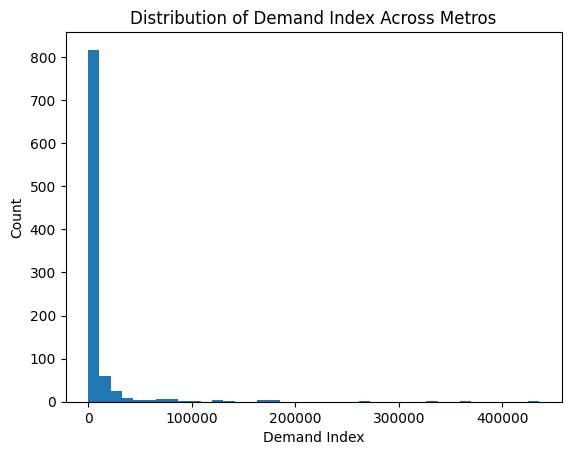

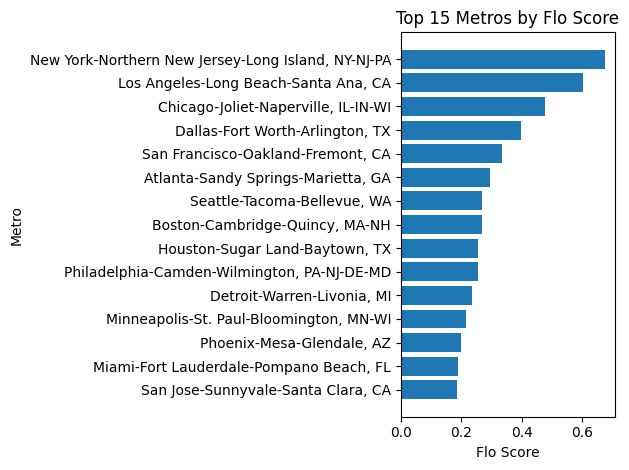

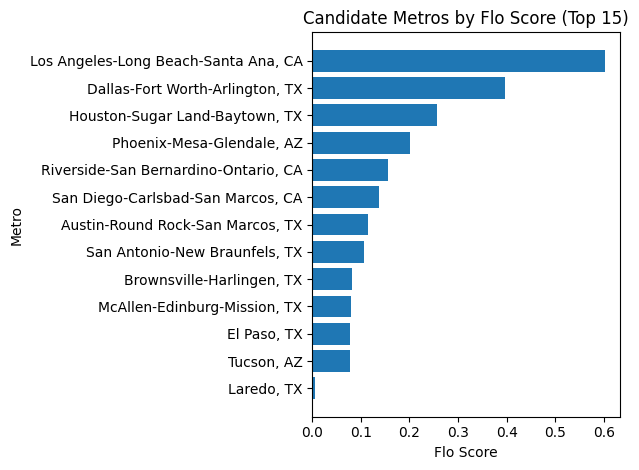

In [9]:
plt.figure()
plt.hist(df["demand_index"], bins=40)
plt.title("Distribution of Demand Index Across Metros")
plt.xlabel("Demand Index")
plt.ylabel("Count")
plt.show()

top15 = df.head(15).copy()
plt.figure()
plt.barh(top15["cbsa_name"][::-1], top15["score_flo"][::-1])
plt.title("Top 15 Metros by Flo Score")
plt.xlabel("Flo Score")
plt.ylabel("Metro")
plt.tight_layout()
plt.show()

cand = df[df["is_candidate"] == True].copy().sort_values("score_flo", ascending=False)
if len(cand) > 0:
    c = cand.head(min(15, len(cand)))
    plt.figure()
    plt.barh(c["cbsa_name"][::-1], c["score_flo"][::-1])
    plt.title("Candidate Metros by Flo Score (Top 15)")
    plt.xlabel("Flo Score")
    plt.ylabel("Metro")
    plt.tight_layout()
    plt.show()
else:
    print("No candidates tagged; skipping candidate chart.")


Section 9 — Sensitivity analysis (vary demand weight, keep others proportional)

In [10]:
weight_grid = [0.50, 0.60, 0.70, 0.80, 0.90]
rows = []

# Base other weights (excluding demand), normalized to sum to 1 in magnitude space
other_keys = ["enterprise_fit", "cloud_adjacency", "resilience", "capex_friction"]
other_raw = np.array([BASE_WEIGHTS.get(k, 0.0) for k in other_keys], dtype=float)

# Avoid divide-by-zero if someone sets all other weights to 0
other_sum = np.sum(np.abs(other_raw))
if other_sum == 0:
    other_scaled = other_raw
else:
    other_scaled = other_raw / other_sum

for w_demand in weight_grid:
    w_other_total = 1.0 - w_demand
    other_w = other_scaled * w_other_total

    score = (
        w_demand * df["demand_norm"] +
        other_w[0] * df["enterprise_fit_norm"] +
        other_w[1] * df["cloud_adjacency_norm"] +
        other_w[2] * df["resilience_norm"] +
        other_w[3] * df["capex_friction_norm"]
    )

    tmp = df[["cbsa_code","cbsa_name","state","is_candidate","demand_index"]].copy()
    tmp["w_demand"] = w_demand
    tmp["score"] = score
    tmp = tmp.sort_values("score", ascending=False).reset_index(drop=True)
    tmp["rank"] = tmp.index + 1

    rows.append(tmp.head(50))

sens = pd.concat(rows, ignore_index=True)
sens_path = OUT_DIR / "sensitivity_results.csv"
sens.to_csv(sens_path, index=False)

print("Saved:", sens_path)
sens.head(20)


Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/sensitivity_results.csv


,cbsa_code,cbsa_name,state,is_candidate,demand_index,w_demand,score,rank
0,35620,"New York-Northern New Jersey-Long Island, NY-N...",NY-NJ-PA,False,435371.1,0.5,0.767412,1
1,31100,"Los Angeles-Long Beach-Santa Ana, CA",CA,True,364492.3,0.5,0.670052,2
2,16980,"Chicago-Joliet-Naperville, IL-IN-WI",IL-IN-WI,False,337400.7,0.5,0.562889,3
3,19100,"Dallas-Fort Worth-Arlington, TX",TX,True,266468.5,0.5,0.458756,4
4,41860,"San Francisco-Oakland-Fremont, CA",CA,False,163292.5,0.5,0.346407,5
5,12060,"Atlanta-Sandy Springs-Marietta, GA",GA,False,183007.9,0.5,0.330796,6
6,14460,"Boston-Cambridge-Quincy, MA-NH",MA-NH,False,168960.8,0.5,0.301787,7
7,26420,"Houston-Sugar Land-Baytown, TX",TX,True,176497.7,0.5,0.298589,8
8,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PA-NJ-DE-MD,False,169456.6,0.5,0.293840,9
9,19820,"Detroit-Warren-Livonia, MI",MI,False,166614.3,0.5,0.277310,10


Section 10 — Final deliverable export

In [11]:
deliverable_cols = [
    "cbsa_code","cbsa_name","state","primary_city",
    "manufacturing","logistics","information","finance","professional_services",
    "demand_index","demand_norm",
    "enterprise_fit","cloud_adjacency","resilience","capex_friction",
    "score_baseline","rank_baseline",
    "score_flo","rank_flo",
    "is_candidate"
]
deliverable_cols = [c for c in deliverable_cols if c in df.columns]

deliverable = df.loc[:, deliverable_cols].copy()
deliverable_path = OUT_DIR / "deliverable_scoring_table.csv"
deliverable.to_csv(deliverable_path, index=False)

print("Saved:", deliverable_path)
deliverable.head(10)


Saved: /Users/lilsebo/Downloads/flo_capex_model/outputs/deliverable_scoring_table.csv


,cbsa_code,cbsa_name,state,primary_city,manufacturing,logistics,information,finance,professional_services,demand_index,demand_norm,enterprise_fit,cloud_adjacency,resilience,capex_friction,score_baseline,rank_baseline,score_flo,rank_flo,is_candidate
0,35620,"New York-Northern New Jersey-Long Island, NY-N...",NY-NJ-PA,New York,295829,358394,347947,548831,773191,435371.1,1.000000,320855.0,347947,0.771178,14.658883,1.000000,1,0.674376,1,False
1,31100,"Los Angeles-Long Beach-Santa Ana, CA",CA,Los Angeles,442058,234186,258653,258711,457711,364492.3,0.837191,358909.2,258653,0.782317,14.317086,0.837191,2,0.603196,2,True
2,16980,"Chicago-Joliet-Naperville, IL-IN-WI",IL-IN-WI,Chicago,376158,267322,98209,274845,396282,337400.7,0.774961,332623.6,98209,0.771959,14.161096,0.774961,3,0.478060,3,False
3,19100,"Dallas-Fort Worth-Arlington, TX",TX,Dallas,277698,239546,101692,253949,290653,266468.5,0.612029,262437.2,101692,0.782978,13.966977,0.612029,4,0.397446,4,True
4,41860,"San Francisco-Oakland-Fremont, CA",CA,San Francisco,140542,92132,256276,144823,324769,163292.5,0.375032,121178.0,256276,0.760159,13.773170,0.375032,11,0.334957,5,False
5,12060,"Atlanta-Sandy Springs-Marietta, GA",GA,Atlanta,162084,178898,105783,129779,257635,183007.9,0.420319,168809.6,105783,0.780580,13.634204,0.420319,5,0.294987,6,False
6,42660,"Seattle-Tacoma-Bellevue, WA",WA,Seattle,153703,79366,164888,68442,168775,125890.2,0.289119,123968.2,164888,0.776225,13.361656,0.289119,14,0.268119,7,False
7,14460,"Boston-Cambridge-Quincy, MA-NH",MA-NH,Boston,167982,75791,121099,154149,318079,168960.8,0.388052,131105.6,121099,0.752313,13.637700,0.388052,9,0.267280,8,False
8,26420,"Houston-Sugar Land-Baytown, TX",TX,Houston,199467,140676,42633,97303,223889,176497.7,0.405365,175950.6,42633,0.755860,13.464490,0.405365,7,0.255879,9,True
9,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PA-NJ-DE-MD,Philadelphia,171911,121225,70269,184391,229428,169456.6,0.389191,151636.6,70269,0.775155,13.563485,0.389191,8,0.255700,10,False
